# 프로젝트 : 주식 예측에 도전해 보자🤑📈📉💸

## STEP 1 : 시계열 데이터 준비
* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
* 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import os
from pmdarima.arima import ndiffs
import pmdarima as pm

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행
* 결측치 처리
* 로그 변환

In [2]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

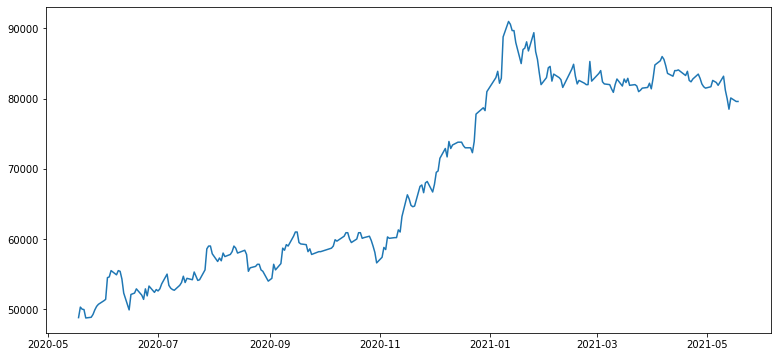

In [3]:
# 로그 변환
ts_log = np.log(ts)
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

## STEP 3 : 시계열 안정성 분석
* 정성적 그래프 분석 : 수치를 통한 분석 외의 분석을 말함
* 정량적 Augmented Dicky-Fuller Test
  1. 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후, 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에
  2. 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택한다
* 시계열 분해(Time Series Decomposition) : statsmodels 라이브러리 안에는 seasonal_decompose 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있습니다. 이 기능을 활용하면 우리가 위에서 직접 수행했던 moving average 제거, differencing 등을 거치지 않고도 훨씬 안정적인 시계열을 분리해 낼 수 있게 됩니다.
* Residual 안정성 확인 : Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual이라고 합니다. 뒤집어서 말하면 Trend+Seasonality+Residual=Original 이 성립한다는 뜻입니다. 이러한 Decomposing은 시계열 데이터를 이해하는 중요한 관점을 제시해 줍니다.

In [4]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [5]:
from statsmodels.tsa.stattools import adfuller
# statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지입니다.

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

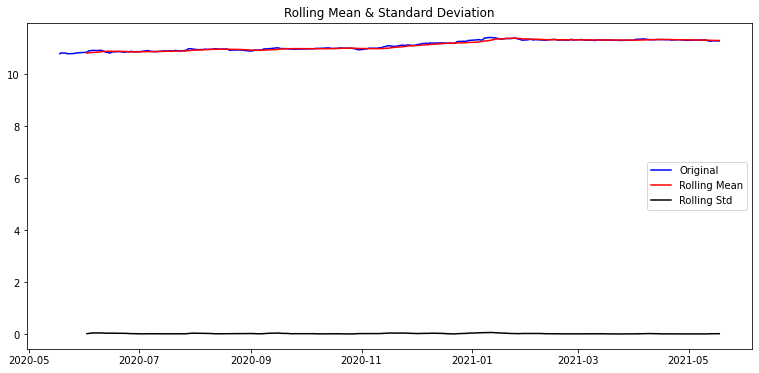

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [6]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

* 귀무가설: 주어진 시계열 데이터는 안정적이지 않다.
* 대립가설: 주어진 시계열 데이터는 안정적이다.

라고 가설을 세웠을 때 p-value의 값이 0.590149로 유의수준인 0.05보다 훨씬 크므로 귀무가설을 기각할 수 없다.
그러므로 귀무가설을 채택 -> 데이터가 안정적이지 않음

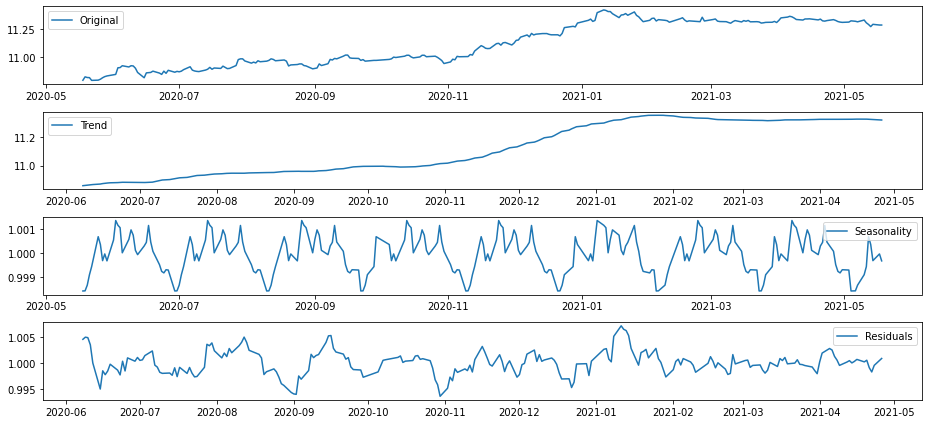

In [7]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
# statsmodels 라이브러리에 seasonal_decompose 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있음.
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [8]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


* Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여 줍니다. 이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠습니다.

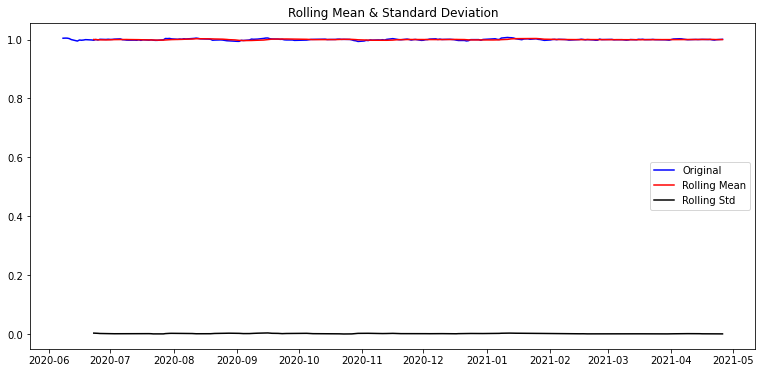

In [9]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

## STEP 4 : 학습, 테스트 데이터셋 생성
* 학습, 테스트 데이터셋 분리

## ARIMA모델이란?
* 앞에서 시계열 데이터가 Trend와 Seasonality, Residual로 분해되는 것을 확인했습니다, 또, Trend와 Seasonality를 잘 분리해 낸 경우 Residual이 예측력 있는 안정적인 시계열 데이터가 되는 것을 확인하였습니다.
* ARIMA(Autoregressive Integrated Moving Average)를 사용하면 이 원리를 이용해 시계열 데이터 예측 모델을 자동으로 만들 수 있습니다.
* ARIMA는 AR(Autoregressive) + I(Integrated) + MA(Moving Average) 라고 할 수 있는데, 각각의 개념을 살펴보면 지금까지 배운 개념과 닮아 있음을 알게 됩니다.

  1. AR(자기회귀) : 과거 값들에 대한 회귀로 미래 값을 예측하는 방법. 시계열의 Residual에 해당하는 부분을 모델링함. 주식값이 항상 일정한 균형 수준을 유지할 것이라고 예측하는 관점이 바로 주식 시계열을 AR로 모델링하는 관점이라고 볼 수 있다.
  2. MA(이동평균) : 예측치가 이전 q개의 예측오차값들의 가중합으로 수렴한다고 보는 모델. 시계열의 Trend에 해당하는 부분을 모델링함. 주식값이 최근의 증감 패턴을 지속할 것이라고 보는 관점이 MA로 모델링하는 관점이라고 볼 수 있습니다.
  3.  I(차분 누적) : 예측치가 이전 데이터와 dd차 차분의 누적(integration) 합이라고 보는 모델. 시계열의 Seasonality에 해당하는 부분을 모델링함.
  

* ARIMA는 위 3가지 모델을 모두 한꺼번에 고려함. 어제 주식값이 떨어졌다는 것을 알게 되었을 때, '오늘은 주식이 올라서 균형을 맞추겠지?'라는 AR 형태의 기대와, '어제 떨어졌으니 추세적으로 계속 떨어지지 않을까?'라는 MA 형태의 우려가 동시에 떠오르게 되는데, ARIMA는 두 모델 사이에서 적정 수준을 찾아가는 능력을 보여 줍니다.

## ARIMA 모델의 모수 p, q, d
* ARIMA를 효과적으로 활용하기 위해서는 ARIMA의 모수(parameter)를 잘 설정해야 합니다. 핵심적인 숫자들을 잘 정해야 올바른 예측식을 구할 수 있다는 것이지요.

  1. p : 자기회귀 모형(AR)의 시차
  2. d : 차분 누적(I) 횟수
  3. q : 이동평균 모형(MA)의 시차
  
  
* 이들 중 p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻입니다. 이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문입니다.


* ARIMA의 적절한 모수 p, d, q를 선택하는 방법으로 많은 통계학적인 시도들이 있지만 대표적인 것만 이야기하면 ACF(Autocorrelation Function)와 PACF(Partial Autocorrelation Function)를 말할 수 있습니다. 이 AutoCorrelation은 우리가 맨 첫 스텝에서 다룬 개념 중 하나인 자기상관계수와 같은 것입니다.

  1. ACF : 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수. 주어진 시계열의 현재 값이 과거 값과 어떻게 상관되는지 설명함. ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄
  2. PACF : 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수. k 이외의 모든 시차를 갖는 관측치의 영향력을 배제한 가운데 특정 두 관측치 y_t와 y_{t-k}가 얼마나 관련이 있는지 나타내는 척도.

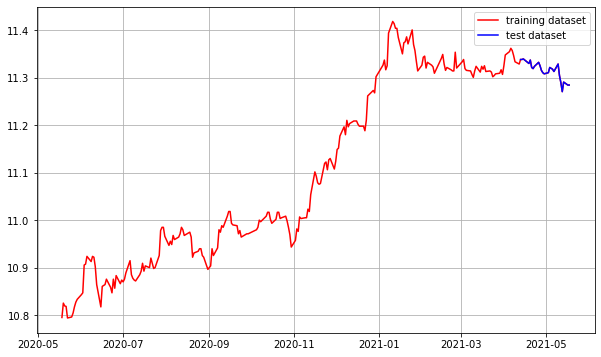

In [10]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


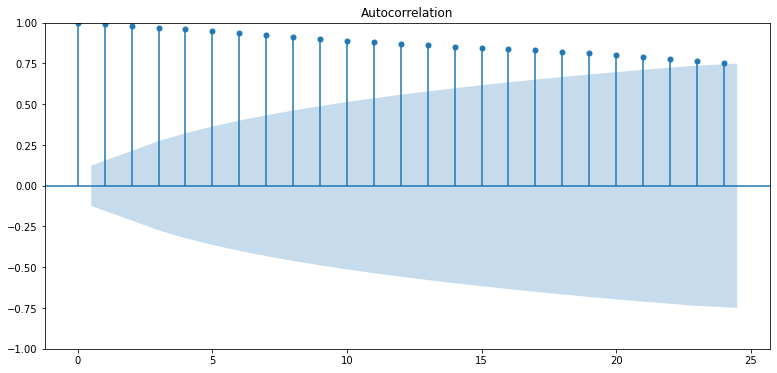

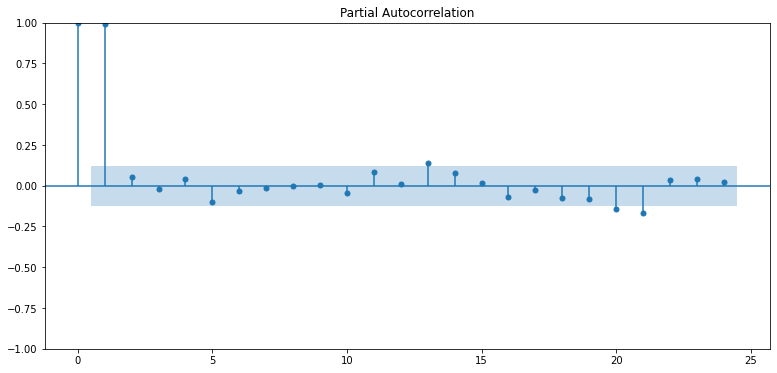

In [11]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


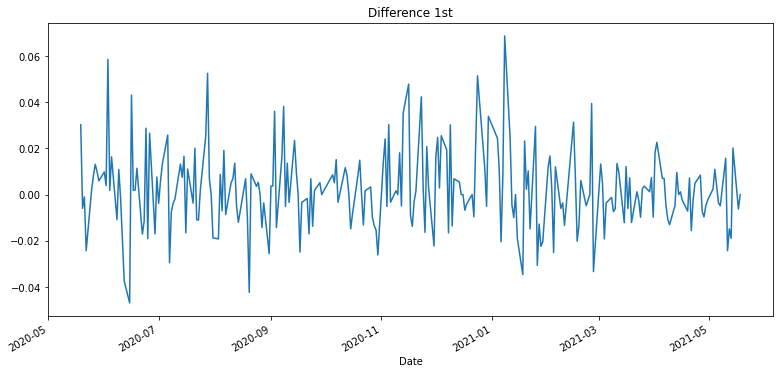

In [12]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


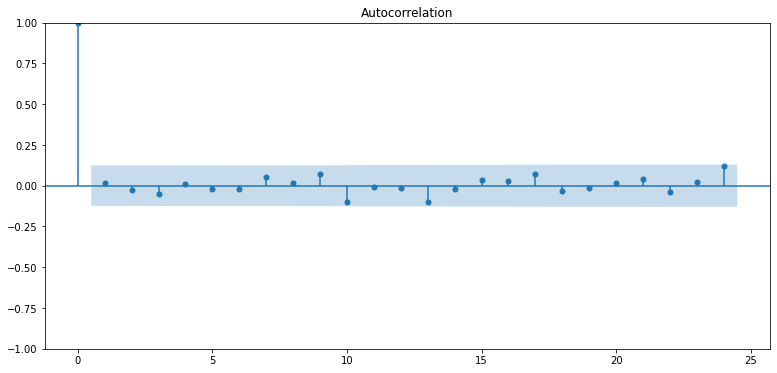

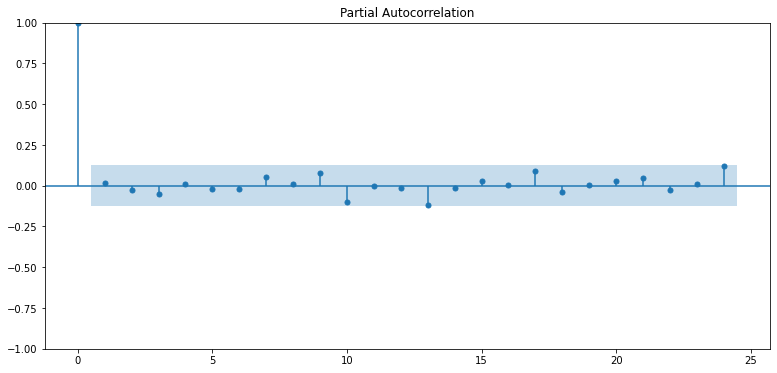

In [13]:
plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


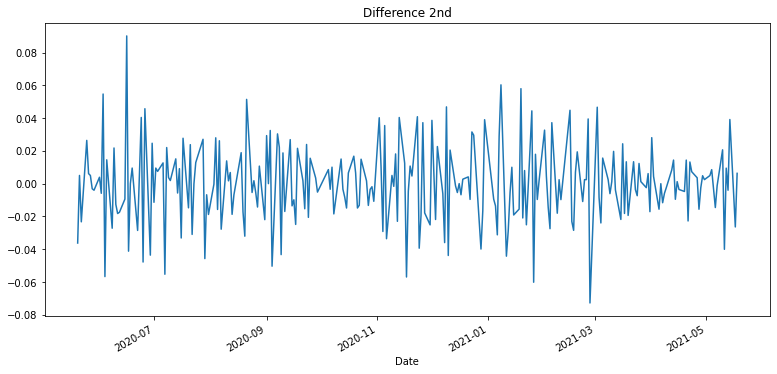

In [14]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


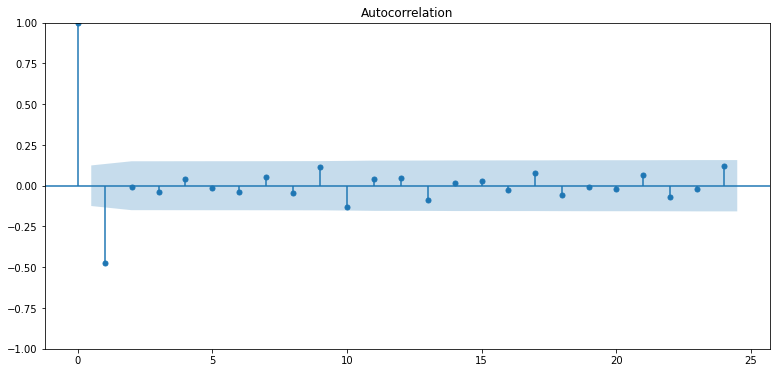

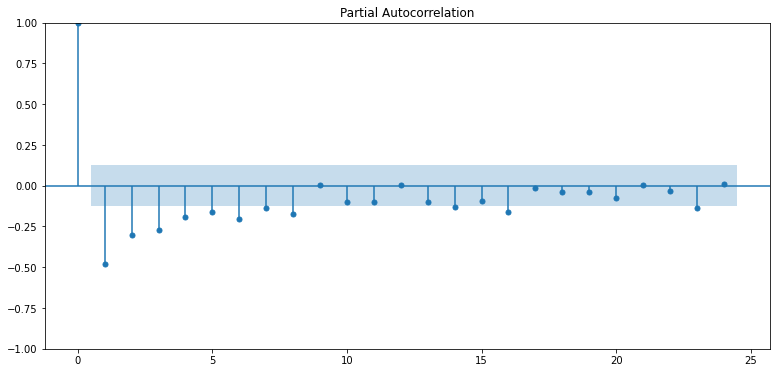

In [15]:
plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

## STEP 6 : ARIMA 모델 훈련과 테스트
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

In [16]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  # p, d, q
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.488
Date:                Wed, 16 Feb 2022   AIC                          -1162.976
Time:                        14:58:51   BIC                          -1156.153
Sample:                             0   HQIC                         -1160.222
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


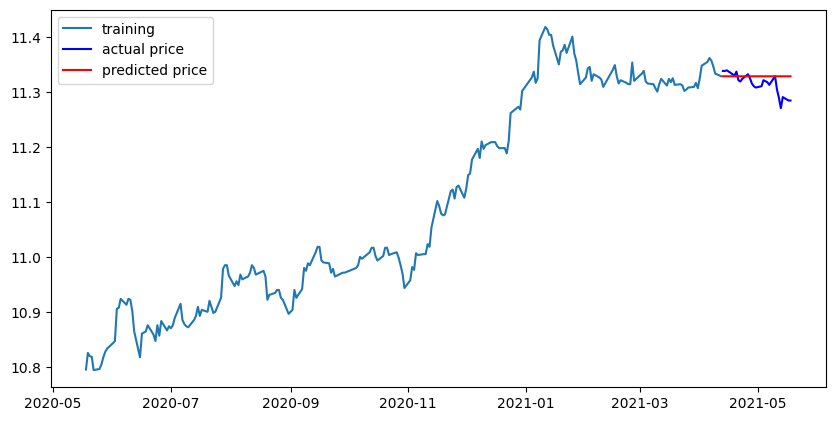

In [17]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3480513.747715865
MAE:  1403.033723618997
RMSE:  1865.6135043775453
MAPE: 1.74%


## AUTOARIMA로 모수 찾기

In [19]:
# 차분이 필요한지, 필요하다면 몇 차 차분이 최선인지 파악하려면 ndiffs 함수를 이용
kpss_diffs = ndiffs(train_data, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_data, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [20]:
model = pm.auto_arima (train_data, d = 1, seasonal = False, trace = True)
model.fit(train_data)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1159.385, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1166.730, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1164.792, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1164.794, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1164.726, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1162.816, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.414 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [21]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(0, 1, 0))  # p, d, q
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 583.363
Date:                Wed, 16 Feb 2022   AIC                          -1164.726
Time:                        14:58:51   BIC                          -1161.314
Sample:                             0   HQIC                         -1163.349
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   2.33e-05     13.751      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                22.25
Prob(Q):                              0.80   Pr

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


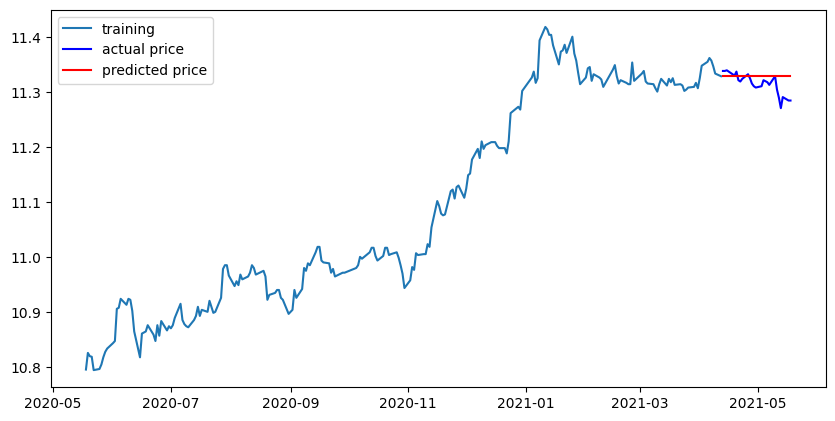

In [22]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3509600.000000066
MAE:  1408.0000000000023
RMSE:  1873.3926443754567
MAPE: 1.74%


* AUTOARIMA가 예측한 모수인 (0,1,0)도 MAPE가 낮게 나왔지만 차분이 1이고 AR모델을 고려하는 모수인 (1, 1, 0)의 MAPE도 매우 낮게 나왔다. 신기하다. 그런데 수치가 생각보다 더 낮게 나와서 당황스럽다(⊙_⊙;)

## STEP 7 : 다른 주식 종목 예측해 보기
* PC 칩셋 3대장 회사인 INTEL, AMD, NVIDIA의 5년치 데이터를 가져와서 예측하겠습니다.🧐

In [1]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/'

df_nvda = os.path.join(dataset_filepath, 'NVDA.csv')
df_amd = os.path.join(dataset_filepath, 'AMD.csv')
df_intc = os.path.join(dataset_filepath, 'INTC.csv')

df_nvda = pd.read_csv(df_nvda, index_col='Date', parse_dates=True)
df_amd = pd.read_csv(df_amd, index_col='Date', parse_dates=True)
df_intc = pd.read_csv(df_intc, index_col='Date', parse_dates=True)

ts_nvda = df_nvda['Close']
ts_amd = df_amd['Close']
ts_intc = df_intc['Close']

print(ts_nvda.head())

print(ts_amd.head())

print(ts_intc.head())

Date
2017-02-16    26.812500
2017-02-17    26.807501
2017-02-21    27.767500
2017-02-22    27.690001
2017-02-23    25.122499
Name: Close, dtype: float64
Date
2017-02-16    12.97
2017-02-17    13.13
2017-02-21    14.00
2017-02-22    14.28
2017-02-23    14.32
Name: Close, dtype: float64
Date
2017-02-16    36.41
2017-02-17    36.48
2017-02-21    36.52
2017-02-22    36.07
2017-02-23    36.18
Name: Close, dtype: float64


# 1. NVIDIA

In [2]:
#결측치 처리
ts_nvda = ts_nvda.interpolate(method='time')
ts_nvda[ts_nvda.isna()]

Series([], Name: Close, dtype: float64)

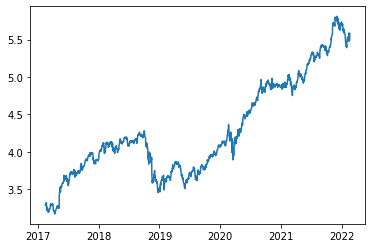

In [3]:
#로그 변환
ts_log_nvda = np.log(ts_nvda)
plt.plot(ts_log_nvda)

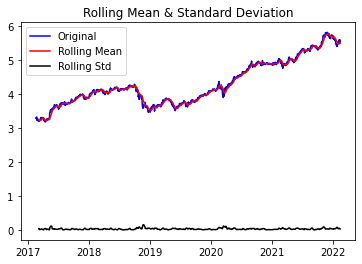

Results of Dickey-Fuller Test:
Test Statistic                   -0.307467
p-value                           0.924440
#Lags Used                        8.000000
Number of Observations Used    1250.000000
Critical Value (1%)              -3.435592
Critical Value (5%)              -2.863855
Critical Value (10%)             -2.568003
dtype: float64


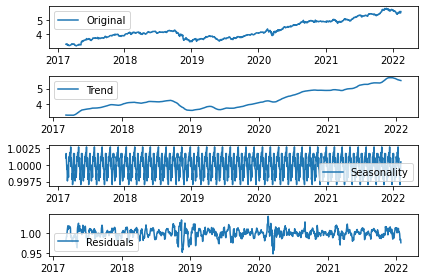

In [5]:
#정성적 그래프 분석
plot_rolling_statistics(ts_log_nvda, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_nvda)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_nvda, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log_nvda, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [6]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.814309e+00
p-value                        5.549907e-17
#Lags Used                     1.800000e+01
Number of Observations Used    1.210000e+03
Critical Value (1%)           -3.435766e+00
Critical Value (5%)           -2.863932e+00
Critical Value (10%)          -2.568043e+00
dtype: float64


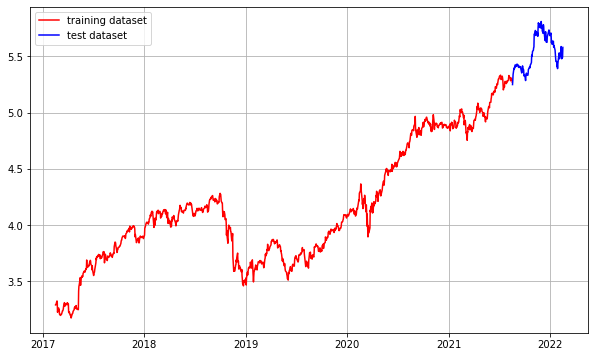

In [7]:
train_data, test_data = ts_log_nvda[:int(len(ts_log_nvda)*0.9)], ts_log_nvda[int(len(ts_log_nvda)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


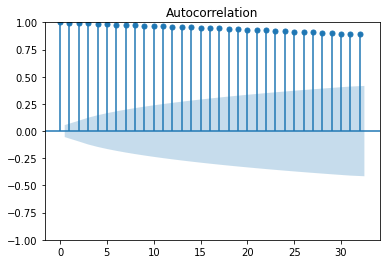

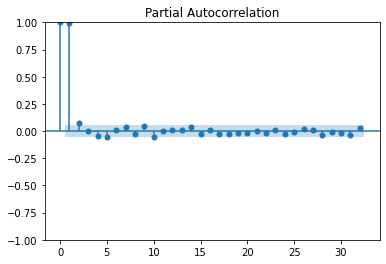

In [8]:
plot_acf(ts_log_nvda)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log_nvda)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.314853e+01
p-value                        1.382191e-24
#Lags Used                     7.000000e+00
Number of Observations Used    1.250000e+03
Critical Value (1%)           -3.435592e+00
Critical Value (5%)           -2.863855e+00
Critical Value (10%)          -2.568003e+00
dtype: float64


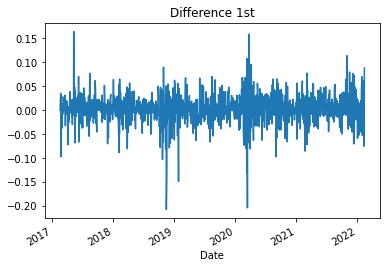

In [9]:
# 차분 안정성 확인, d 구하기
diff_1 = ts_log_nvda.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.275807e+01
p-value                        8.256819e-24
#Lags Used                     2.100000e+01
Number of Observations Used    1.235000e+03
Critical Value (1%)           -3.435656e+00
Critical Value (5%)           -2.863883e+00
Critical Value (10%)          -2.568018e+00
dtype: float64


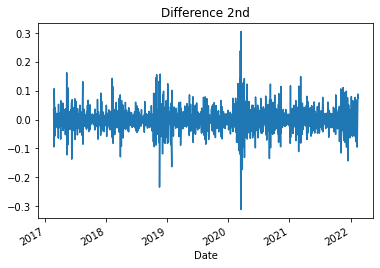

In [10]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

* AR모델을 사용하고 1차 차분을 선택하여 (p,d,q)=(1,1,0)으로 모델을 빌드해보겠습니다.

In [17]:
model = ARIMA(train_data, order=(1,1,0))
fitted_m = model.fit() 
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1133
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2376.082
Date:                Thu, 17 Feb 2022   AIC                          -4748.164
Time:                        01:30:18   BIC                          -4738.101
Sample:                             0   HQIC                         -4744.362
                               - 1133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1203      0.016     -7.482      0.000      -0.152      -0.089
sigma2         0.0009    1.8e-05     48.839      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.01   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


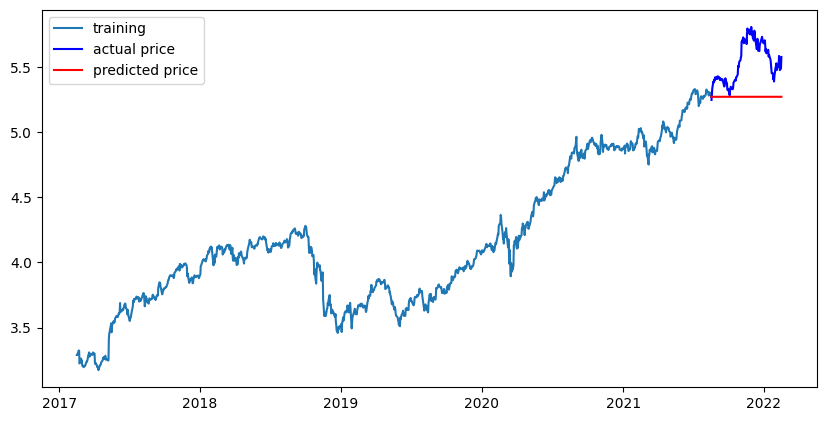

In [18]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [19]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  5260.869382296835
MAE:  61.134870378370316
RMSE:  72.53185081256947
MAPE: 22.11%


* MAPE가 22.11%로 너무 높게 나왔으로 AUTOARIMA를 사용하여 적정 모수를 찾아보겠습니다.

In [20]:
# 차분이 필요한지, 필요하다면 몇 차 차분이 최선인지 파악하려면 ndiffs 함수를 이용
kpss_diffs = ndiffs(train_data, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_data, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [21]:
model = pm.auto_arima (train_data, d = 1, seasonal = False, trace = True)
model.fit(train_data)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4749.008, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4735.568, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4751.157, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4749.238, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4733.674, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4752.253, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4750.856, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4750.286, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4751.177, Time=0.36 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4748.824, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4749.776, Time=0.09 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.938 seconds


ARIMA(order=(2, 1, 0), scoring_args={}, suppress_warnings=True)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1133
Model:                 ARIMA(2, 1, 0)   Log Likelihood                2377.888
Date:                Thu, 17 Feb 2022   AIC                          -4749.776
Time:                        01:41:02   BIC                          -4734.681
Sample:                             0   HQIC                         -4744.073
                               - 1133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1135      0.017     -6.608      0.000      -0.147      -0.080
ar.L2          0.0565      0.022      2.599      0.009       0.014       0.099
sigma2         0.0009    1.8e-05     48.767      0.0

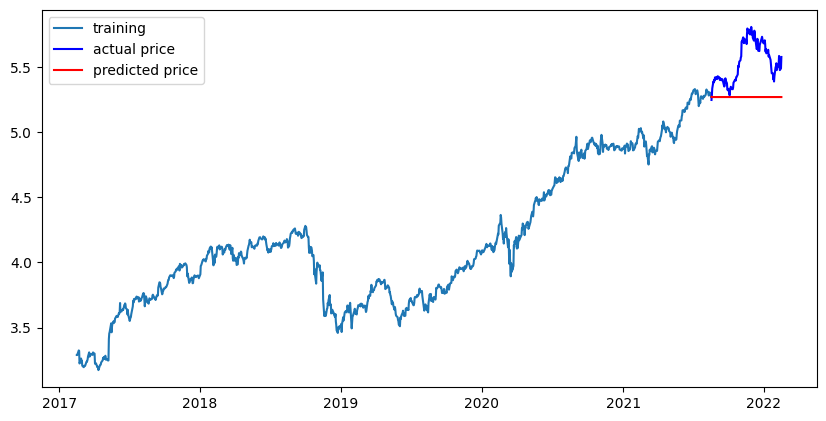

MSE:  5307.882649805506
MAE:  61.51430793552888
RMSE:  72.85521703903919
MAPE: 22.26%


In [101]:
model = ARIMA(train_data, order=(2,1,0))
fitted_m = model.fit() 
print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

* (2,1,0)의 MAPE도 22.26%로 신뢰할만한 정확도로 볼 수 없다. AUTOARIMA의 모수예측도 완벽하지는 않은듯 하다.

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1133
Model:                 ARIMA(1, 3, 3)   Log Likelihood                2351.999
Date:                Thu, 17 Feb 2022   AIC                          -4693.998
Time:                        01:39:49   BIC                          -4668.848
Sample:                             0   HQIC                         -4684.496
                               - 1133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9996      0.020    -50.931      0.000      -1.038      -0.961
ma.L1         -0.9959      0.355     -2.806      0.005      -1.691      -0.300
ma.L2         -1.0000      0.609     -1.643      0.1

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


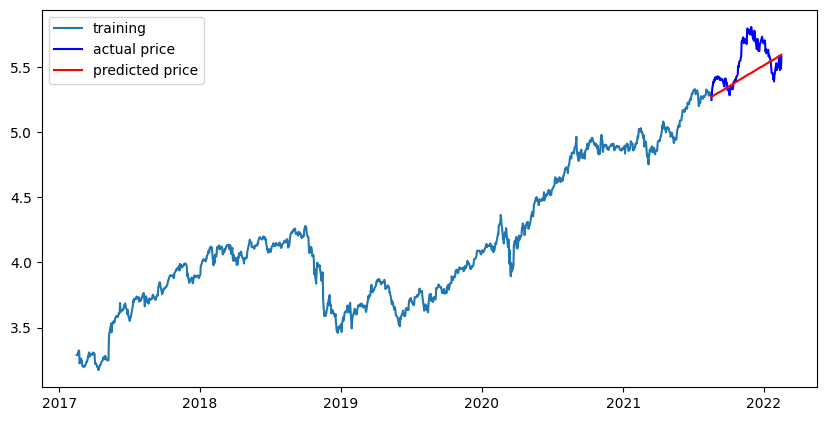

MSE:  1878.133864488255
MAE:  33.68952124038274
RMSE:  43.33744183138012
MAPE: 12.08%


In [100]:
model = ARIMA(train_data, order=(1,3,3))
fitted_m = model.fit() 
print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

* 여러 시도 끝에 MAPE 12.08%를 얻었다. 아주 낮진 않지만 이정도면 신뢰할만한 듯 하다.

# 2. AMD

In [102]:
#결측치 처리
ts_amd = ts_amd.interpolate(method='time')
ts_amd[ts_amd.isna()]

Series([], Name: Close, dtype: float64)

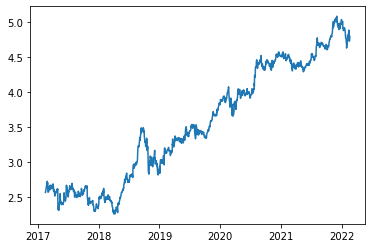

In [103]:
#로그 변환
ts_log_amd = np.log(ts_amd)
plt.plot(ts_log_amd)

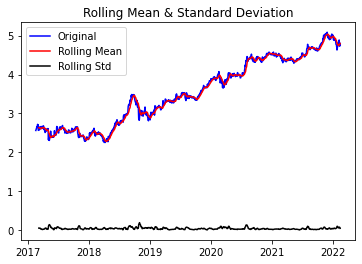

Results of Dickey-Fuller Test:
Test Statistic                   -0.136677
p-value                           0.945661
#Lags Used                        8.000000
Number of Observations Used    1250.000000
Critical Value (1%)              -3.435592
Critical Value (5%)              -2.863855
Critical Value (10%)             -2.568003
dtype: float64


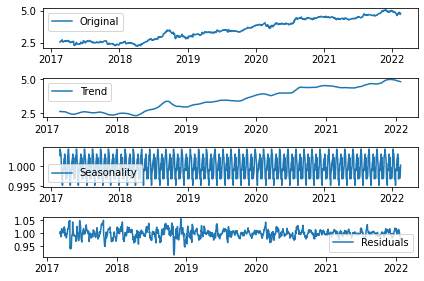

In [104]:
#정성적 그래프 분석
plot_rolling_statistics(ts_log_amd, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_amd)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_amd, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log_amd, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [105]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.773312e+00
p-value                        7.041572e-17
#Lags Used                     1.700000e+01
Number of Observations Used    1.211000e+03
Critical Value (1%)           -3.435761e+00
Critical Value (5%)           -2.863930e+00
Critical Value (10%)          -2.568042e+00
dtype: float64


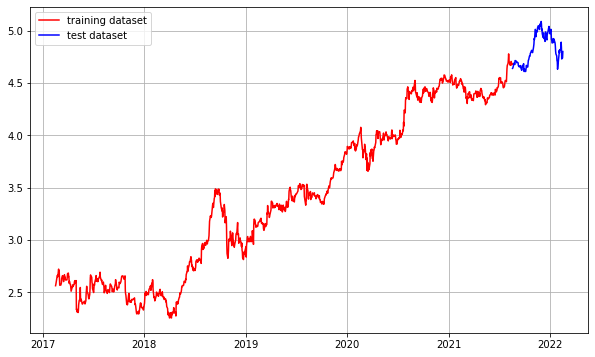

In [106]:
train_data, test_data = ts_log_amd[:int(len(ts_log_amd)*0.9)], ts_log_amd[int(len(ts_log_amd)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


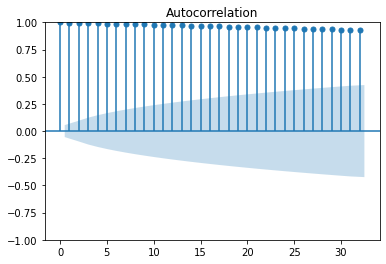

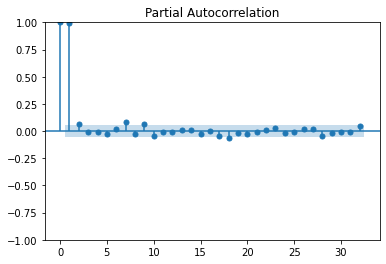

In [107]:
plot_acf(ts_log_amd)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log_amd)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.417264e+01
p-value                        1.990915e-26
#Lags Used                     7.000000e+00
Number of Observations Used    1.250000e+03
Critical Value (1%)           -3.435592e+00
Critical Value (5%)           -2.863855e+00
Critical Value (10%)          -2.568003e+00
dtype: float64


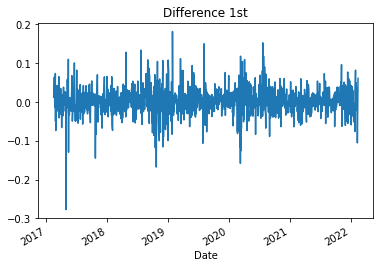

In [108]:
# 차분 안정성 확인, d 구하기
diff_1 = ts_log_amd.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.639806e+01
p-value                        2.654589e-29
#Lags Used                     1.600000e+01
Number of Observations Used    1.240000e+03
Critical Value (1%)           -3.435635e+00
Critical Value (5%)           -2.863874e+00
Critical Value (10%)          -2.568012e+00
dtype: float64


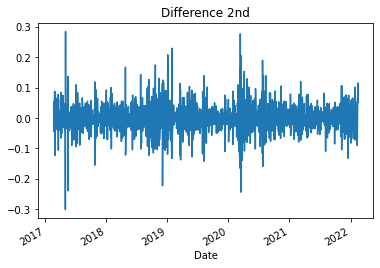

In [109]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [113]:
# 차분이 필요한지, 필요하다면 몇 차 차분이 최선인지 파악하려면 ndiffs 함수를 이용
kpss_diffs = ndiffs(train_data, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_data, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [114]:
model = pm.auto_arima (train_data, d = 1, seasonal = False, trace = True)
model.fit(train_data)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4341.149, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4326.227, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4328.486, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4327.930, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4325.136, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4334.288, Time=0.90 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4333.797, Time=0.73 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-4331.603, Time=1.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-4333.508, Time=3.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4332.905, Time=0.75 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-4333.770, Time=1.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4333.536, Time=0.46 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-4333.636, Time=0.71 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-4339.778, Time=0.53 sec

Best model:  ARIMA

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1133
Model:                 ARIMA(2, 1, 2)   Log Likelihood                2174.889
Date:                Thu, 17 Feb 2022   AIC                          -4339.778
Time:                        02:07:34   BIC                          -4314.619
Sample:                             0   HQIC                         -4330.274
                               - 1133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3880      0.122    -11.348      0.000      -1.628      -1.148
ar.L2         -0.7380      0.096     -7.654      0.000      -0.927      -0.549
ma.L1          1.3431      0.118     11.399      0.0

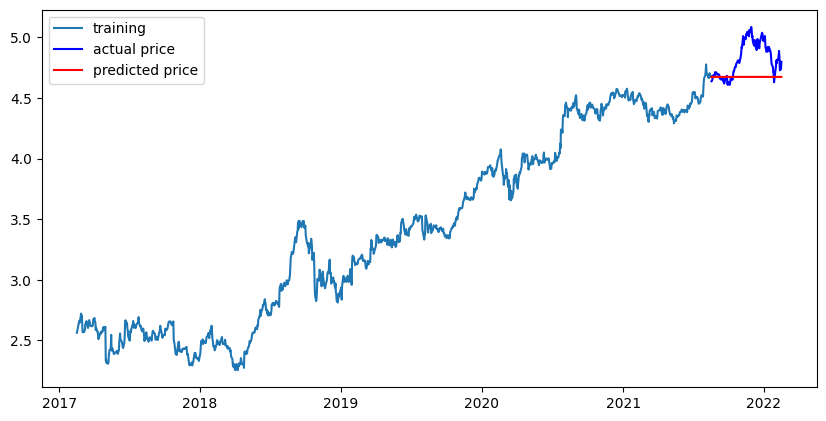

MSE:  642.7813195558813
MAE:  19.438844153956758
RMSE:  25.353132342096927
MAPE: 14.04%


In [127]:
model = ARIMA(train_data, order=(2,1,2))
fitted_m = model.fit() 
print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1133
Model:                 ARIMA(3, 2, 3)   Log Likelihood                2168.277
Date:                Thu, 17 Feb 2022   AIC                          -4322.554
Time:                        01:53:07   BIC                          -4287.338
Sample:                             0   HQIC                         -4309.250
                               - 1133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5665      0.065    -23.996      0.000      -1.694      -1.439
ar.L2         -0.8998      0.082    -10.993      0.000      -1.060      -0.739
ar.L3         -0.0083      0.028     -0.294      0.7

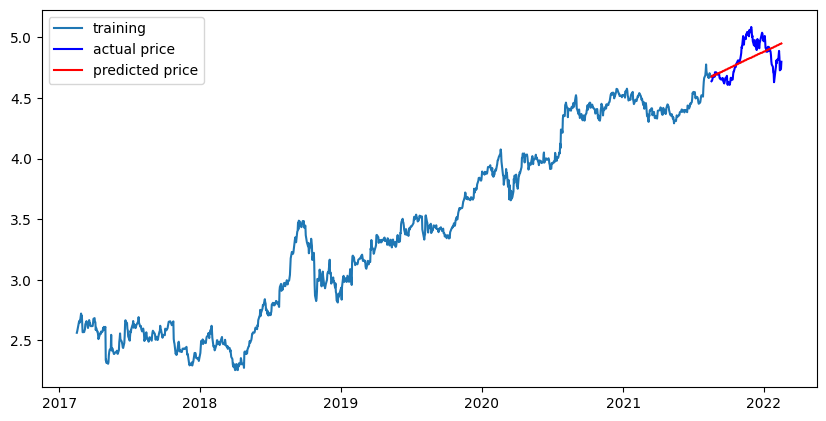

MSE:  245.67496711839172
MAE:  12.421499419742982
RMSE:  15.674022046634734
MAPE: 9.64%


In [124]:
model = ARIMA(train_data, order=(2,2,3))
fitted_m = model.fit() 
print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

* 역시 AUTOARIMA로 예측한 모수보다 MAPE가 낮게나오는 모수가 존재했다.

# 3. INTEL

In [128]:
#결측치 처리
ts_intc = ts_intc.interpolate(method='time')
ts_intc[ts_intc.isna()]

Series([], Name: Close, dtype: float64)

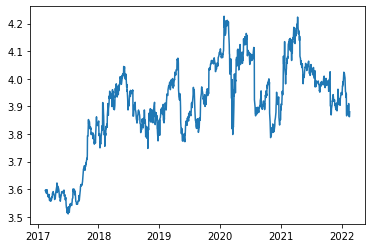

In [129]:
#로그 변환
ts_log_intc = np.log(ts_intc)
plt.plot(ts_log_intc)

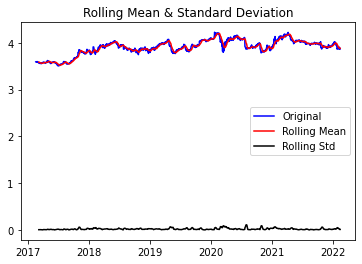

Results of Dickey-Fuller Test:
Test Statistic                   -2.722559
p-value                           0.070215
#Lags Used                        9.000000
Number of Observations Used    1249.000000
Critical Value (1%)              -3.435596
Critical Value (5%)              -2.863857
Critical Value (10%)             -2.568004
dtype: float64


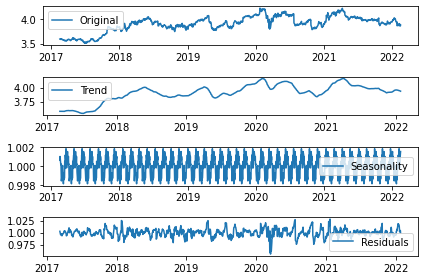

In [130]:
#정성적 그래프 분석
plot_rolling_statistics(ts_log_intc, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_intc)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_intc, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log_intc, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [131]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.275261e+01
p-value                        8.470832e-24
#Lags Used                     1.000000e+01
Number of Observations Used    1.218000e+03
Critical Value (1%)           -3.435730e+00
Critical Value (5%)           -2.863916e+00
Critical Value (10%)          -2.568035e+00
dtype: float64


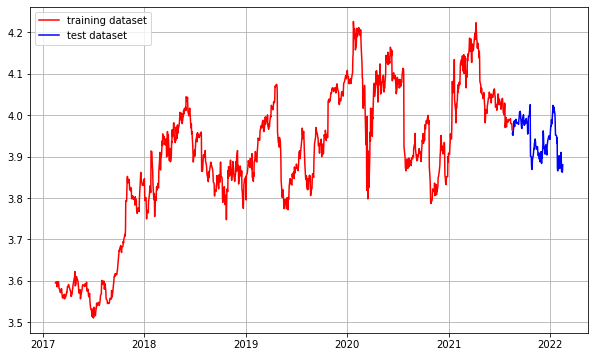

In [132]:
train_data, test_data = ts_log_intc[:int(len(ts_log_intc)*0.9)], ts_log_intc[int(len(ts_log_intc)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


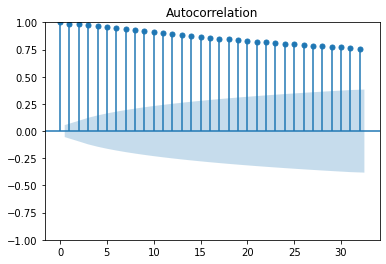

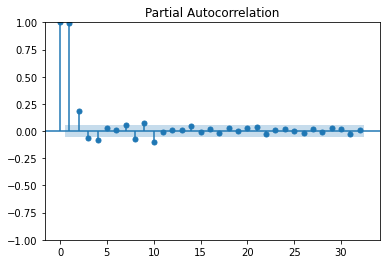

In [133]:
plot_acf(ts_log_intc)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log_intc)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.139925e+01
p-value                        7.720781e-21
#Lags Used                     8.000000e+00
Number of Observations Used    1.249000e+03
Critical Value (1%)           -3.435596e+00
Critical Value (5%)           -2.863857e+00
Critical Value (10%)          -2.568004e+00
dtype: float64


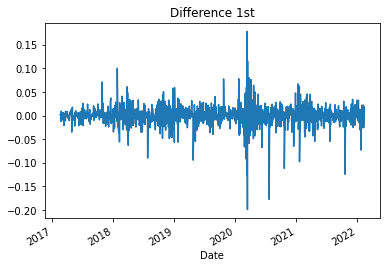

In [134]:
# 차분 안정성 확인, d 구하기
diff_1 = ts_log_intc.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.241278e+01
p-value                        4.306502e-23
#Lags Used                     2.300000e+01
Number of Observations Used    1.233000e+03
Critical Value (1%)           -3.435665e+00
Critical Value (5%)           -2.863887e+00
Critical Value (10%)          -2.568020e+00
dtype: float64


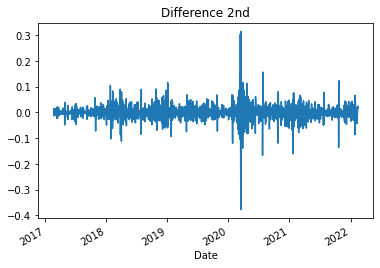

In [135]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [137]:
# 차분이 필요한지, 필요하다면 몇 차 차분이 최선인지 파악하려면 ndiffs 함수를 이용
kpss_diffs = ndiffs(train_data, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_data, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [172]:
model = pm.auto_arima (train_data, d = 1, seasonal = False, trace = True)
model.fit(train_data)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5434.161, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5369.964, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5424.212, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5415.056, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5371.727, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5433.894, Time=1.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5428.627, Time=0.96 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-5431.812, Time=0.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5432.436, Time=3.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5424.357, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5433.561, Time=2.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5432.726, Time=1.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-5430.021, Time=3.61 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-5435.416, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0

ARIMA(order=(1, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1133
Model:                 ARIMA(1, 1, 3)   Log Likelihood                2727.922
Date:                Thu, 17 Feb 2022   AIC                          -5445.844
Time:                        02:13:17   BIC                          -5420.686
Sample:                             0   HQIC                         -5436.340
                               - 1133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8028      0.073    -11.018      0.000      -0.946      -0.660
ma.L1          0.5941      0.075      7.887      0.000       0.447       0.742
ma.L2         -0.0517      0.031     -1.685      0.0

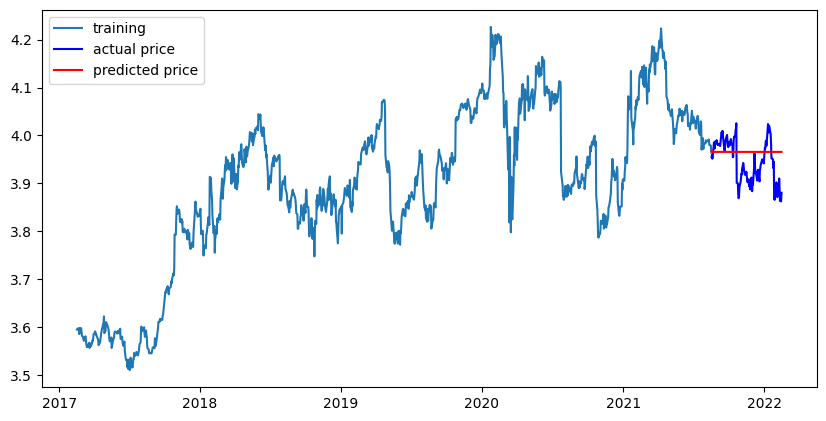

MSE:  6.062171150858805
MAE:  2.085974972374753
RMSE:  2.46214767040054
MAPE: 4.11%


In [139]:
model = ARIMA(train_data, order=(1,1,3))
fitted_m = model.fit() 
print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1133
Model:                 ARIMA(3, 2, 3)   Log Likelihood                2712.381
Date:                Thu, 17 Feb 2022   AIC                          -5410.762
Time:                        02:22:09   BIC                          -5375.546
Sample:                             0   HQIC                         -5397.457
                               - 1133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.0300      0.112    -18.174      0.000      -2.249      -1.811
ar.L2         -1.2719      0.134     -9.505      0.000      -1.534      -1.010
ar.L3         -0.1973      0.037     -5.276      0.0

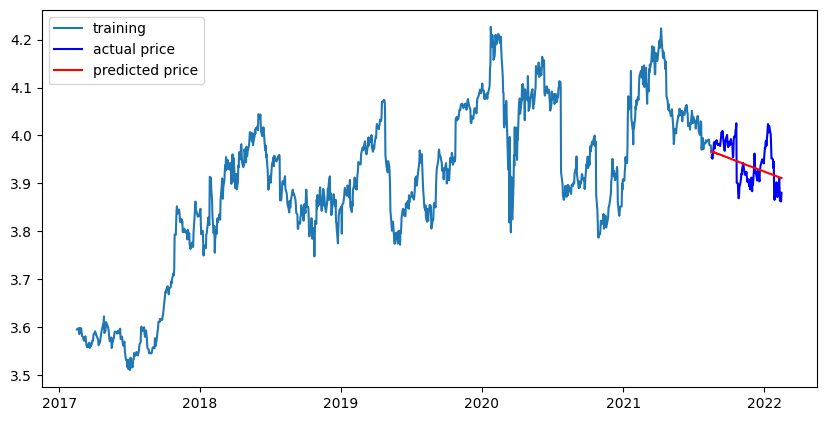

MSE:  4.214029837289088
MAE:  1.702504143238983
RMSE:  2.052810229244069
MAPE: 3.27%


In [177]:
model = ARIMA(train_data, order=(3,2,3))
fitted_m = model.fit() 
print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

# 정리 & 회고🤔
* AUTOARIMA 모수 예측치보다 MAPE가 낮게 나오는 모수가 존재하는 경우가 많았고, 대체로 차수가 2차 이상이고 AR, MA모델을 동시에 고려하는 조합이 정확도가 높게 나왔다.
* 시계열 데이터를 분석해보고 미래의 주가를 예측하는 과정이 굉장히 흥미로웠고, 모수를 설정하는 과정도 여러 시도를 통해 MAPE가 낮아지는 것을 보며 보람을 느꼈다. 모수를 깔끔하게 추정하는 방법에 대해서는 더 공부가 필요할 것 같다. 